In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Bipolar to Monopolar LFP Power Estimation Companion
---------------------------------------------------
This notebook provides an interactive interface to help
you estimate Monopolar LFP Powers from Bipolar LFP Power
using the weights and model described in Fleeting et al.,
2025. Input requires a csv file

Author: Chance Fleeting
"""

import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path
import matplotlib.pyplot as plt

## Coefficients from Fleeting et al. 2025
beta = pd.DataFrame({
    'C0': [3.931926, 0.737293,  0.076522, 0.101754],
    'C1': [4.738096, 0.410390,  0.393244, 0.125366],
    'C2': [4.953907, 0.284265,  0.157266, 0.488739],
    'C3': [3.844596, 0.564074, -0.043996, 0.409325],
    }, index=['const', 'C0-C3', 'C1-C2', 'C2-C3']) # <-------- Please use these Contacts and Labels in your CSV

iv = list(beta.index)[1:]    # ['C0-C3', 'C1-C2', 'C2-C3']
dv = list(beta.columns)  # ['C0','C1','C2','C3']

In [2]:
## Helper Functions
def plot_regression(df_true, df_estimated, dv, iv=None, title=None, 
                    figsize=(12, 3)):
    """
    Modular function to plot actual vs. predicted regression results,
    showing Adjusted R2 and RMSE.
    """
    n_targets = len(dv)
    ncols = 4
    nrows = int(np.ceil(n_targets / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes_flat = axes.ravel()

    # Flatten data for global axis limits
    all_true = np.concatenate([df_true[t].values for t in dv])
    all_pred = np.concatenate([df_estimated[t].values for t in dv])

    plot_min, plot_max = -20, 45
    
    k = True
    for ax, target_name in zip(axes_flat, dv):
        actual_vals = df_true[target_name].values
        predicted_vals = df_estimated[target_name].values

        ax.scatter(actual_vals, predicted_vals, alpha=0.7, s=20, edgecolors='none')
        ax.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', lw=2)

        # Compute adjusted R2
        ss_res = np.sum((actual_vals - predicted_vals)**2)
        ss_tot = np.sum((actual_vals - np.mean(actual_vals))**2)
        n = len(actual_vals)
        pn = 1 if iv is None else (len(iv) if isinstance(iv, list) else 1)
        adj_r2 = 1 - (1 - (1 - ss_res/ss_tot)) * (n - 1)/(n - pn - 1)

        # Compute RMSE
        rmse =  np.sqrt(np.mean((actual_vals-predicted_vals)**2))

        # Draw white background text
        text = f"Adj $R^2$ = {adj_r2:.4f}\nRMSE = {rmse:.4f}"
        
        ax.text(0.05, 0.95, text, 
                transform=ax.transAxes, ha='left', va='top', fontsize=9.5,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, pad=0.5))

        ax.set_title(f"{target_name}", fontweight='bold')
        if k:
            ax.set_ylabel((title or f"Regression Results over {iv}") + "\nPredicted Power (dB)")
            k = False
        ax.set_xlabel("Actual Power (dB)")
        ax.set_xlim(plot_min, plot_max)
        ax.set_ylim(plot_min, plot_max)
        
        # Minimalist axes: only x and y axes lines in black, no grid
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_color('k')
        ax.spines['bottom'].set_color('k')
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.tick_params(left=True, bottom=True, right=False, top=False, color='k')
        ax.grid(False)

    # Hide unused subplots
    for ax in axes_flat[len(dv):]:
        ax.axis("off")

    #fig.subplots_adjust(top=0.9, hspace=0.3, wspace=0.3)
    plt.suptitle(title or f"Regression Results over {iv}")
    plt.tight_layout()
    plt.show()

    return plt

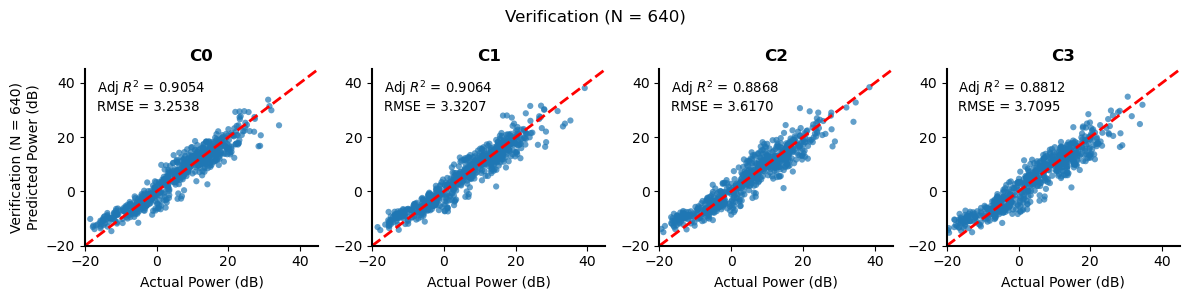

Saved estimated values to: C:\Users\cflee\Documents\GitHub\Research\Bipolar2Monopolar\Example_Data_estimated.csv


In [3]:
## Body
# INPUT Phase

#####_____________________#####
input_file = r".\Example_Data.csv"   # <-- replace with your filename (CSV)
#####_____________________#####

df = pd.read_csv(input_file)
assert all(v in df.columns for v in iv), f"Missing columns: {set(iv) - set(df.columns)}" 

nm = Path(input_file)
df_remainder = df[[c for c in df.columns if c not in iv + dv]]

# COMPUTATION Phase
df_estimated = sm.add_constant(df[iv]) @ beta

# If Monopolar are present, COMPARE true and estimate (and plot)
if all(v in df.columns for v in dv):
    df_true = df[dv]
    # use your plot_regression function (assumed present)
    plot_regression(df_true, df_estimated, dv, iv, title=f"Verification (N = {len(df_true)})")

# SAVE Phase
out_file = nm.with_stem(nm.stem+"_estimated")
pd.concat([df_remainder,df_estimated], axis = 1).to_csv(out_file, index=False)
print("Saved estimated values to:", out_file)